https://stackabuse.com/autoencoders-for-image-reconstruction-in-python-and-keras/

In [2]:
import numpy as np
import pandas as pd
import cv2
import tarfile
#from tqdm import tqdm
from tqdm.notebook import tqdm
import os
import matplotlib.pyplot as plt

The tqdm library provides a progress bar functionality.


## Downloading Dataset

We are downloading the Labeled Faces in the Wild (LFW) dataset by Columbia University.

Then, we download the Deep funneled images, which have been preprocessed to align faces more consistently.

Lastly, we are downloading the files that contains the original images of faces from the LFW dataset before any preprocessing.

In [ ]:
!wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/lfw_attributes.txt
!wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz
!wget http://vis-www.cs.umass.edu/lfw/lfw.tgz

In [4]:
# http://www.cs.columbia.edu/CAVE/databases/pubfig/download/lfw_attributes.txt
ATTRS_NAME = "/content/lfw_attributes.txt"

# http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz
IMAGES_NAME = "/content/lfw-deepfunneled.tgz"

# http://vis-www.cs.umass.edu/lfw/lfw.tgz
RAW_IMAGES_NAME = "/content/lfw.tgz"

In [5]:
def decode_image_from_raw_bytes(raw_bytes):
    img = cv2.imdecode(np.asarray(bytearray(raw_bytes), dtype=np.uint8), 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

The function `decode_image_from_raw_bytes` takes a byte array raw_bytes as input and returns a decoded image.

`bytearray(raw_bytes)` converts the input raw_bytes into a bytearray. Bytearray is a mutable sequence of bytes.
`np.asarray(bytearray(raw_bytes), dtype=np.uint8)` converts the bytearray into a NumPy array with data type uint8, which represents unsigned 8-bit integers.
`cv2.imdecode(...)` decodes the NumPy array into an image. The second parameter (1) specifies to load the image as is, without making any changes.

`cv2.cvtColor(img, cv2.COLOR_BGR2RGB)` converts the color space of the image from BGR (Blue-Green-Red) to RGB (Red-Green-Blue). OpenCV typically loads images in the BGR color space, whereas other libraries (like Matplotlib) expect images in the RGB color space.

In [6]:
def load_lfw_dataset(
        use_raw=False,
        dx=80, dy=80,
        dimx=45, dimy=45):

    # Read attrs
    df_attrs = pd.read_csv(ATTRS_NAME, sep='\t', skiprows=1)
    df_attrs = pd.DataFrame(df_attrs.iloc[:, :-1].values, columns=df_attrs.columns[1:])
    imgs_with_attrs = set(map(tuple, df_attrs[["person", "imagenum"]].values))

    # Read photos
    all_photos = []
    photo_ids = []

    # tqdm in used to show progress bar while reading the data in a notebook here, you can change
    # tqdm_notebook to use it outside a notebook
    with tarfile.open(RAW_IMAGES_NAME if use_raw else IMAGES_NAME) as f:
        for m in tqdm(f.getmembers()):
            # Only process image files from the compressed data
            if m.isfile() and m.name.endswith(".jpg"):
                # Prepare image
                img = decode_image_from_raw_bytes(f.extractfile(m).read())

                # Crop only faces and resize it
                img = img[dy:-dy, dx:-dx]
                img = cv2.resize(img, (dimx, dimy))

                # Parse person and append it to the collected data
                fname = os.path.split(m.name)[-1]
                fname_splitted = fname[:-4].replace('_', ' ').split()
                person_id = ' '.join(fname_splitted[:-1])
                photo_number = int(fname_splitted[-1])
                if (person_id, photo_number) in imgs_with_attrs:
                    all_photos.append(img)
                    photo_ids.append({'person': person_id, 'imagenum': photo_number})

    photo_ids = pd.DataFrame(photo_ids)
    all_photos = np.stack(all_photos).astype('uint8')

    # Preserve photo_ids order!
    all_attrs = photo_ids.merge(df_attrs, on=('person', 'imagenum')).drop(["person", "imagenum"], axis=1)

    return all_photos, all_attrs

`load_lfw_dataset` loads the Labeled Faces in the Wild (LFW) dataset.

***Parameters***

`use_raw`: A boolean parameter indicating whether to use the raw images or the deepfunneled images. Default is False.
`dx` and `dy`: Parameters defining the dimensions for cropping the images. Default values are 80.
`dimx` and `dimy`: Parameters defining the dimensions for resizing the images. Default values are 45.

**Read Attributes**:

It reads the attributes of the LFW dataset from a CSV file (ATTRS_NAME) using Pandas. The attributes file contains information like person's name, image number, and various attributes associated with the images.
It then creates a DataFrame df_attrs to store this information.

**Process Images:**

It initializes empty lists all_photos and photo_ids to store processed images and their corresponding IDs.
It iterates over the contents of a tarfile (RAW_IMAGES_NAME or IMAGES_NAME depending on the value of use_raw), which contains the image files.
For each image file (which ends with ".jpg"), it decodes the image using the decode_image_from_raw_bytes function and performs cropping and resizing operations on it.
It parses the person's name and photo number from the image file name and checks if the image has associated attributes in imgs_with_attrs.
If the image has associated attributes, it appends the processed image to all_photos and adds the corresponding person ID and image number to photo_ids.

**Data Processing:**

It converts photo_ids list into a DataFrame.
It stacks the processed images in all_photos into a NumPy array and converts their data type to uint8.
It merges the photo_ids DataFrame with the attributes DataFrame (df_attrs) based on person and image number.
Finally, it drops the columns "person" and "imagenum" from the merged DataFrame and returns the processed images (all_photos) and their attributes (all_attrs).


In [7]:
X, attr = load_lfw_dataset(use_raw=True, dimx=32, dimy=32)

  0%|          | 0/18983 [00:00<?, ?it/s]

In [8]:
X = X.astype('float32') / 255.0 - 0.5
print(X.max(), X.min())

0.5 -0.5


We convert the data type of array X to float32. Then, divide each element in the array `X` by 255. Since pixel values typically range from 0 to 255 in images, dividing by 255 scales the values to the range [0, 1]. We subtract 0.5 from each element in the array `X`. Subtracting 0.5 then shifts the range of values from [0, 1] to [-0.5, 0.5].

In [9]:
def show_image(x):
    plt.imshow(np.clip(x + 0.5, 0, 1))

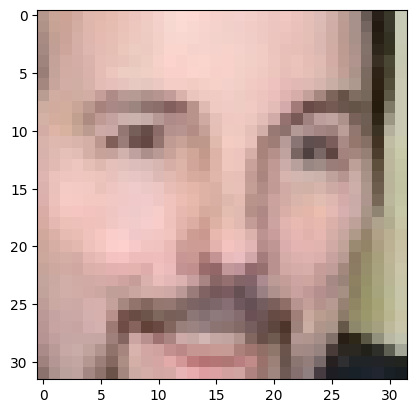

In [12]:
show_image(X[134])

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(X, test_size=0.1, random_state=42)

In [14]:
from keras.layers import Dense, Flatten, Reshape, Input, InputLayer
from keras.models import Sequential, Model

def build_autoencoder(img_shape, code_size):
    # The encoder
    encoder = Sequential()
    encoder.add(InputLayer(img_shape))
    encoder.add(Flatten())
    encoder.add(Dense(code_size))

    # The decoder
    decoder = Sequential()
    decoder.add(InputLayer((code_size,)))
    decoder.add(Dense(np.prod(img_shape))) # np.prod(img_shape) is the same as 32*32*3, it's more generic than saying 3072
    decoder.add(Reshape(img_shape))

    return encoder, decoder

In [15]:
# Same as (32,32,3), we neglect the number of instances from shape
IMG_SHAPE = X.shape[1:]
encoder, decoder = build_autoencoder(IMG_SHAPE, 32)

inp = Input(IMG_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = Model(inp,reconstruction)
autoencoder.compile(optimizer='adamax', loss='mse')

print(autoencoder.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 sequential (Sequential)     (None, 32)                98336     
                                                                 
 sequential_1 (Sequential)   (None, 32, 32, 3)         101376    
                                                                 
Total params: 199712 (780.12 KB)
Trainable params: 199712 (780.12 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [16]:
history = autoencoder.fit(x=X_train, y=X_train, epochs=20,
                validation_data=[X_test, X_test])

Epoch 1/20
370/370 [==============================] - 4s 4ms/step - loss: 0.0144 - val_loss: 0.0101
Epoch 2/20
370/370 [==============================] - 1s 4ms/step - loss: 0.0091 - val_loss: 0.0081
Epoch 3/20
370/370 [==============================] - 1s 3ms/step - loss: 0.0076 - val_loss: 0.0071
Epoch 4/20
370/370 [==============================] - 1s 3ms/step - loss: 0.0069 - val_loss: 0.0067
Epoch 5/20
370/370 [==============================] - 1s 3ms/step - loss: 0.0067 - val_loss: 0.0066
Epoch 6/20
370/370 [==============================] - 1s 3ms/step - loss: 0.0067 - val_loss: 0.0066
Epoch 7/20
370/370 [==============================] - 1s 3ms/step - loss: 0.0066 - val_loss: 0.0066
Epoch 8/20
370/370 [==============================] - 1s 3ms/step - loss: 0.0066 - val_loss: 0.0066
Epoch 9/20
370/370 [==============================] - 1s 3ms/step - loss: 0.0066 - val_loss: 0.0066
Epoch 10/20
370/370 [==============================] - 1s 3ms/step - loss: 0.0066 - val_loss: 0.0066

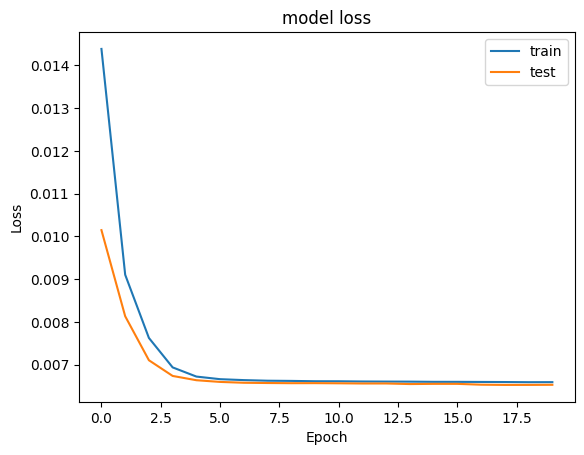

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

1/1 [==============================] - 0s 40ms/step


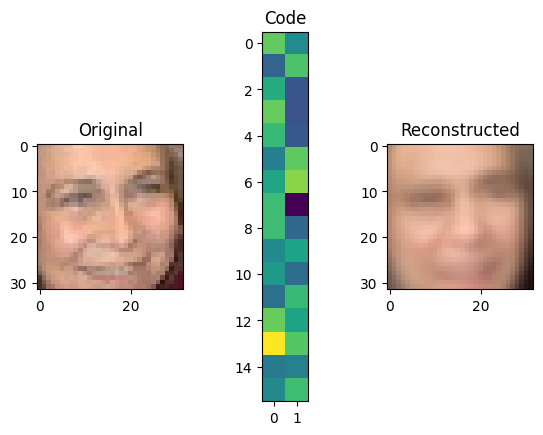

1/1 [==============================] - 0s 23ms/step


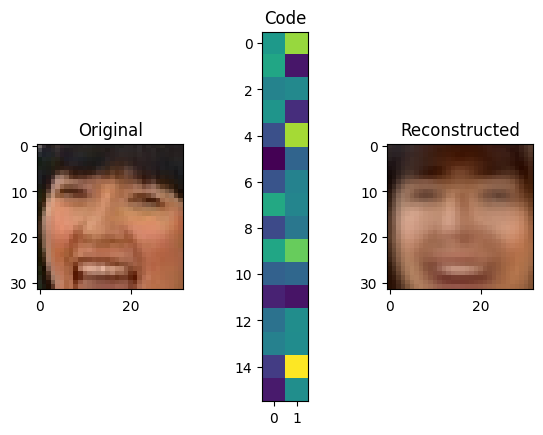

1/1 [==============================] - 0s 26ms/step


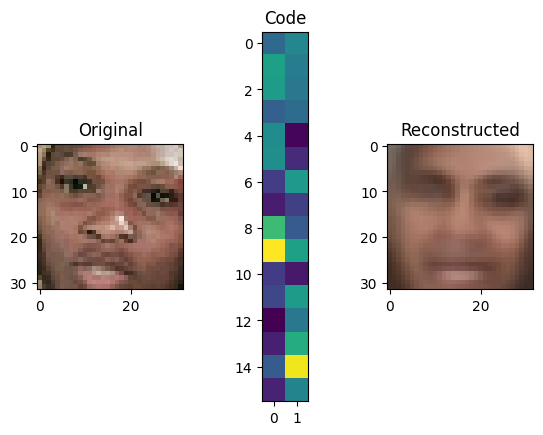

1/1 [==============================] - 0s 17ms/step


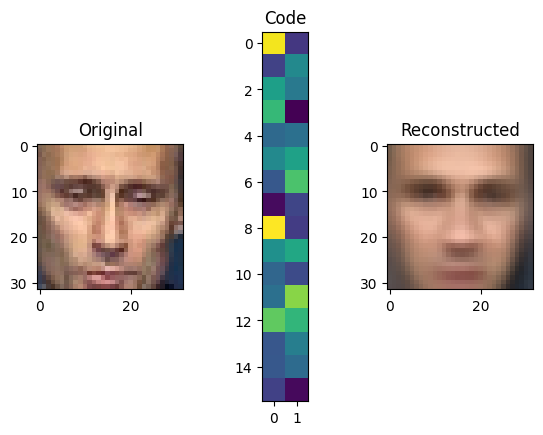

1/1 [==============================] - 0s 15ms/step


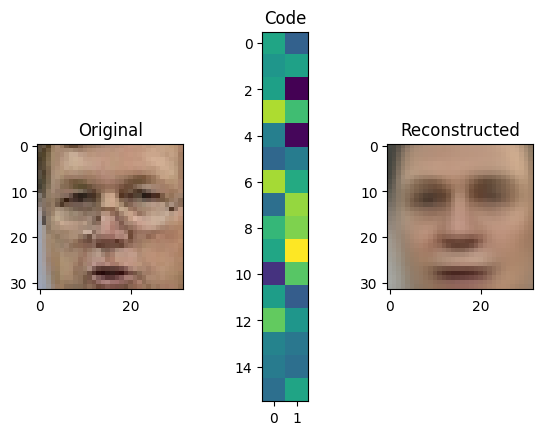

In [18]:
def visualize(img,encoder,decoder):
    """Draws original, encoded and decoded images"""
    # img[None] will have shape of (1, 32, 32, 3) which is the same as the model input
    code = encoder.predict(img[None])[0]
    reco = decoder.predict(code[None])[0]

    plt.subplot(1,3,1)
    plt.title("Original")
    show_image(img)

    plt.subplot(1,3,2)
    plt.title("Code")
    plt.imshow(code.reshape([code.shape[-1]//2,-1]))

    plt.subplot(1,3,3)
    plt.title("Reconstructed")
    show_image(reco)
    plt.show()

for i in range(5):
    img = X_test[i]
    visualize(img,encoder,decoder)

## Image denoising

In [19]:
def apply_gaussian_noise(X, sigma=0.1):
    noise = np.random.normal(loc=0.0, scale=sigma, size=X.shape)
    return X + noise

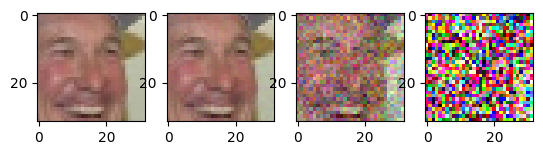

In [20]:
plt.subplot(1,4,1)
show_image(X_train[0])
plt.subplot(1,4,2)
show_image(apply_gaussian_noise(X_train[:1],sigma=0.01)[0])
plt.subplot(1,4,3)
show_image(apply_gaussian_noise(X_train[:1],sigma=0.1)[0])
plt.subplot(1,4,4)
show_image(apply_gaussian_noise(X_train[:1],sigma=0.5)[0])

In [21]:
code_size = 100

# We can use bigger code size for better quality
encoder, decoder = build_autoencoder(IMG_SHAPE, code_size=code_size)

inp = Input(IMG_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = Model(inp, reconstruction)
autoencoder.compile('adamax', 'mse')

for i in range(25):
    print("Epoch %i/25, Generating corrupted samples..."%(i+1))
    X_train_noise = apply_gaussian_noise(X_train)
    X_test_noise = apply_gaussian_noise(X_test)

    # We continue to train our model with new noise-augmented data
    autoencoder.fit(x=X_train_noise, y=X_train, epochs=1,
                    validation_data=[X_test_noise, X_test])

Epoch 1/25, Generating corrupted samples...
370/370 [==============================] - 2s 3ms/step - loss: 0.0131 - val_loss: 0.0087
Epoch 2/25, Generating corrupted samples...
370/370 [==============================] - 1s 3ms/step - loss: 0.0074 - val_loss: 0.0063
Epoch 3/25, Generating corrupted samples...
370/370 [==============================] - 1s 4ms/step - loss: 0.0057 - val_loss: 0.0051
Epoch 4/25, Generating corrupted samples...
370/370 [==============================] - 1s 3ms/step - loss: 0.0048 - val_loss: 0.0045
Epoch 5/25, Generating corrupted samples...
370/370 [==============================] - 1s 3ms/step - loss: 0.0043 - val_loss: 0.0041
Epoch 6/25, Generating corrupted samples...
370/370 [==============================] - 2s 5ms/step - loss: 0.0040 - val_loss: 0.0039
Epoch 7/25, Generating corrupted samples...
370/370 [==============================] - 1s 3ms/step - loss: 0.0039 - val_loss: 0.0038
Epoch 8/25, Generating corrupted samples...
370/370 [================

1/1 [==============================] - 0s 43ms/step


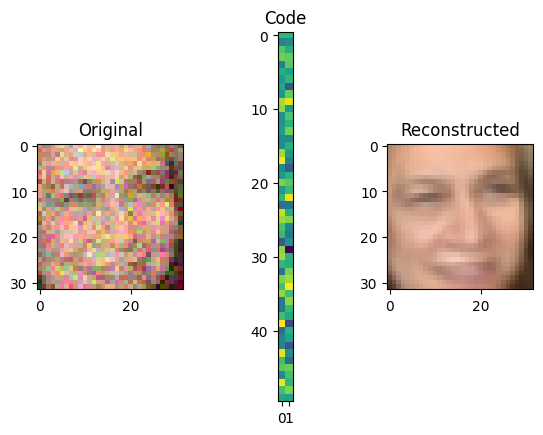

1/1 [==============================] - 0s 20ms/step


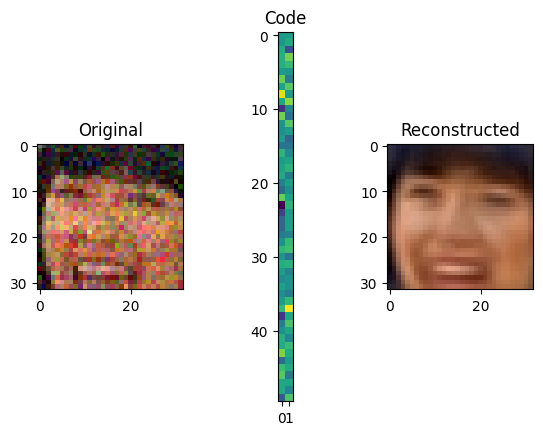

1/1 [==============================] - 0s 16ms/step


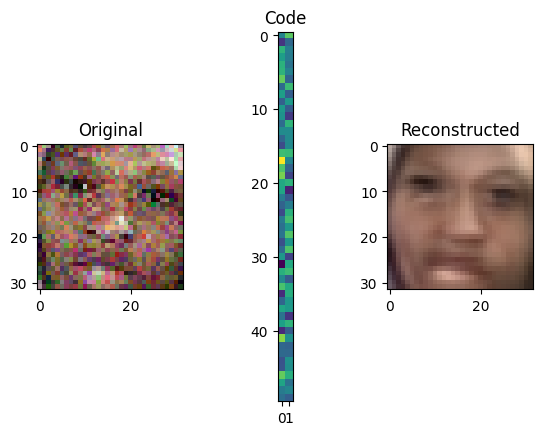

1/1 [==============================] - 0s 16ms/step


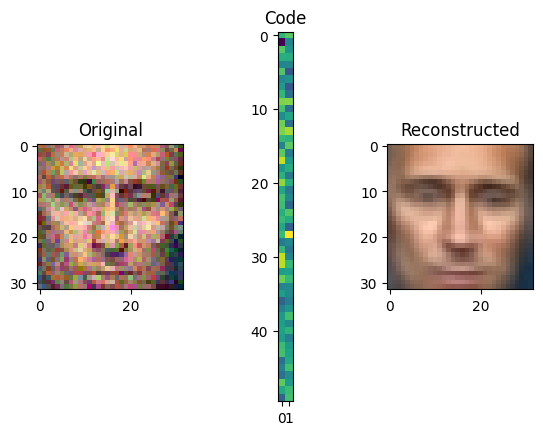

1/1 [==============================] - 0s 26ms/step


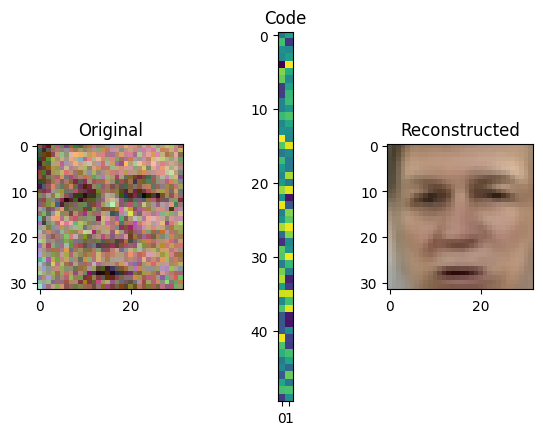

In [22]:
X_test_noise = apply_gaussian_noise(X_test)
for i in range(5):
    img = X_test_noise[i]
    visualize(img,encoder,decoder)